In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time
import pickle
from copy import deepcopy
import re
import pylab

import numpy as np
import scipy as sc
import pandas as pd

import models
import dre
import rna
import designers
import editdistance

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

2024-04-30 01:36:27.840381: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 01:36:27.840422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 01:36:27.841596: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-30 01:36:27.848209: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 01:36:29.795432: W tensorflow/comp

In [2]:
# load selection experiment results computed in rna-selection-041224.ipynb
# df = pd.read_csv('../rna-results/selection-041524.csv', index_col='target_value')
df = pd.read_csv('../rna-results/selection-v2-042924.csv', index_col='target_value')
df.head()

,imp_pval_cbas-ridge-0.1t19,imp_pval_cbas-ridge-0.2t19,imp_pval_cbas-ridge-0.3t19,imp_pval_cbas-ridge-0.4t19,imp_pval_cbas-ridge-0.5t19,imp_pval_cbas-ridge-0.6t19,imp_pval_cbas-ridge-0.7t19,imp_pval_cbas-ridge-0.8t19,imp_pval_cbas-ridge-0.9t19,imp_pval_dbas-ridge-0.1t19,...,tr49_pp_pval_pex-cnn,tr49_pp_pval_dbas-cnn-0.1,tr49_pp_pval_dbas-cnn-0.2,tr49_pp_pval_dbas-cnn-0.3,tr49_pp_pval_dbas-cnn-0.4,tr49_pp_pval_dbas-cnn-0.5,tr49_pp_pval_dbas-cnn-0.6,tr49_pp_pval_dbas-cnn-0.7,tr49_pp_pval_dbas-cnn-0.8,tr49_pp_pval_dbas-cnn-0.9
target_value,,,,,,,,,,,,,,,,,,,,,
0.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# build menu of design algorithm names
adalead_thresholds = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.03, 0.02, 0.015, 0.01, 0.005]
cbas_dbas_quantiles = np.arange(0.1, 0.91, 0.1)

design_names = []
for q in cbas_dbas_quantiles:
    q = round(q, 2)
    design_names.append(f'cbas-ridge-{q}t19')
    
for q in cbas_dbas_quantiles[: 6]:
    q = round(q, 2)
    design_names.append(f'dbas-ridge-{q}t19')
    
for model_name in ['ridge', 'ff', 'cnn']:
    
    
    for thresh in adalead_thresholds:
        thresh = round(thresh, 4)
        design_names.append(f'adalead-{model_name}-{thresh}')
        
    for temp in biswas_temperatures:
        temp = round(temp, 4)
        design_names.append(f'biswas-{model_name}-{temp}') 
    
    design_names.append(f'pex-{model_name}') 
        
    if model_name != 'ridge':
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'dbas-{model_name}-{q}')
            
print(f'{len(design_names)} design names:')
for name in design_names:
    print(f'  {name}')

84 design names:
  cbas-ridge-0.1t19
  cbas-ridge-0.2t19
  cbas-ridge-0.3t19
  cbas-ridge-0.4t19
  cbas-ridge-0.5t19
  cbas-ridge-0.6t19
  cbas-ridge-0.7t19
  cbas-ridge-0.8t19
  cbas-ridge-0.9t19
  dbas-ridge-0.1t19
  dbas-ridge-0.2t19
  dbas-ridge-0.3t19
  dbas-ridge-0.4t19
  dbas-ridge-0.5t19
  dbas-ridge-0.6t19
  adalead-ridge-0.5
  adalead-ridge-0.45
  adalead-ridge-0.4
  adalead-ridge-0.35
  adalead-ridge-0.3
  adalead-ridge-0.25
  adalead-ridge-0.2
  adalead-ridge-0.15
  adalead-ridge-0.1
  adalead-ridge-0.05
  adalead-ridge-0.01
  biswas-ridge-0.03
  biswas-ridge-0.02
  biswas-ridge-0.015
  biswas-ridge-0.01
  biswas-ridge-0.005
  pex-ridge
  adalead-ff-0.5
  adalead-ff-0.45
  adalead-ff-0.4
  adalead-ff-0.35
  adalead-ff-0.3
  adalead-ff-0.25
  adalead-ff-0.2
  adalead-ff-0.15
  adalead-ff-0.1
  adalead-ff-0.05
  adalead-ff-0.01
  biswas-ff-0.03
  biswas-ff-0.02
  biswas-ff-0.015
  biswas-ff-0.01
  biswas-ff-0.005
  pex-ff
  dbas-ff-0.1
  dbas-ff-0.2
  dbas-ff-0.3
  dbas-ff-0.

In [4]:
# load design data, to access ground-truth labels for selection experiments (and scatterplot below)
design_pkl_fname = '/homefs/home/wongfanc/density-ratio-estimation/rna-results/designs-041124-copy.pkl'
with open(design_pkl_fname, 'rb') as f:
    name2designdata = pickle.load(f)

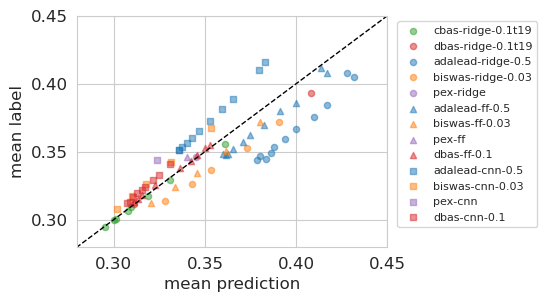

In [5]:
# scatterplot of mean prediction vs. mean label
target_values = np.arange(0.28, 0.61, 0.01)
cm = pylab.get_cmap('tab10')
plt.figure(figsize=(4, 3))

def name2color(name):
    if 'adalead' in name:
        return cm(0)
    if 'biswas' in name:
        return cm(1)
    if 'cbas' in name:
        return cm(2)
    if 'dbas' in name:
        return cm(3)
    if 'pex' in name:
        return cm(4)
def name2marker(name):
    if 'ridge' in name:
        return 'o'
    if 'ff' in name:
        return '^'
    if 'cnn' in name:
        return 's'

plt.plot(
    [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
    [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
    '--k', linewidth=1
);
used_colormarkers = []
for name in design_names:
    color = name2color(name)
    marker = name2marker(name)
    tag = (color, marker)
    plt.scatter(
        np.mean(name2designdata[name][2]),
        np.mean(name2designdata[name][1]),
        color=color, marker=marker, alpha=0.5, label=name if tag not in used_colormarkers else None, s=20
    )
    used_colormarkers.append(tag)
plt.legend(fontsize=8, bbox_to_anchor=(1.5, 1))
plt.xlabel('mean prediction'); plt.ylabel('mean label');
plt.xlim([0.28, 0.45]);
plt.ylim([0.28, 0.45]);

In [8]:
# compute plottable quantities
target_values = np.arange(0.28, 0.4501, 0.005)
n_trial = 27
alpha_bonferroni = 0.1 / len(design_names)

impworst_v = []
imperr_v = []
impdisc_v = []

ppworst_v = []
pperr_v = []
ppdisc_v = []

val2imperrnames = {}
val2pperrnames = {} # TODO

t0 = time()
for v, val in enumerate(target_values):
    val = round(val, 4)
    
    # ----- imputation -----
    imp_selected_minmax_t = []
    
    imp_selected = [n for n in design_names if df.loc[val][f'imp_pval_{n}'] < alpha_bonferroni]
    imp_achieved = [np.mean(name2designdata[n][1]) for n in imp_selected]
    if len(imp_selected):
        impworst_v.append(np.min(imp_achieved))
        err = np.min(imp_achieved) < val
        imperr_v.append(err.astype(float))
        impdisc_v.append(True)
        
        if err:
            err_idx = np.where(imp_achieved < val)[0]
            err_names = [imp_selected[i] for i in err_idx]
            val2imperrnames[val] = err_names
        else:
            val2imperrnames[val] = []
    else:
        impworst_v.append(np.nan)
        imperr_v.append(0.)
        impdisc_v.append(False)
        val2imperrnames[val] = []
        
    # ----- PP -----
    pp_worst_t = []
    errname2t = {name: 0 for name in design_names}
    
    for t in range(n_trial):
        pp_selected = [n for n in design_names if df.loc[val][f'tr{t}_pp_pval_{n}'] < alpha_bonferroni]
        pp_achieved = [np.mean(name2designdata[n][1]) for n in pp_selected]
        if len(pp_selected):
            pp_worst_t.append(np.min(pp_achieved))
            # if no discovery/selection, no worst achieved value
            
            err_idx = np.where(pp_achieved < val)[0]
            err_names = [pp_selected[i] for i in err_idx]
            for name in err_names:
                errname2t[name] += 1
            
    ppworst_v.append(pp_worst_t)
    pperr_v.append(np.sum(np.array(pp_worst_t) < val) / n_trial) 
    ppdisc_v.append(len(pp_worst_t) / n_trial)
    val2pperrnames[val] = errname2t

print('{} s'.format(int(time() - t0)))
    

2 s


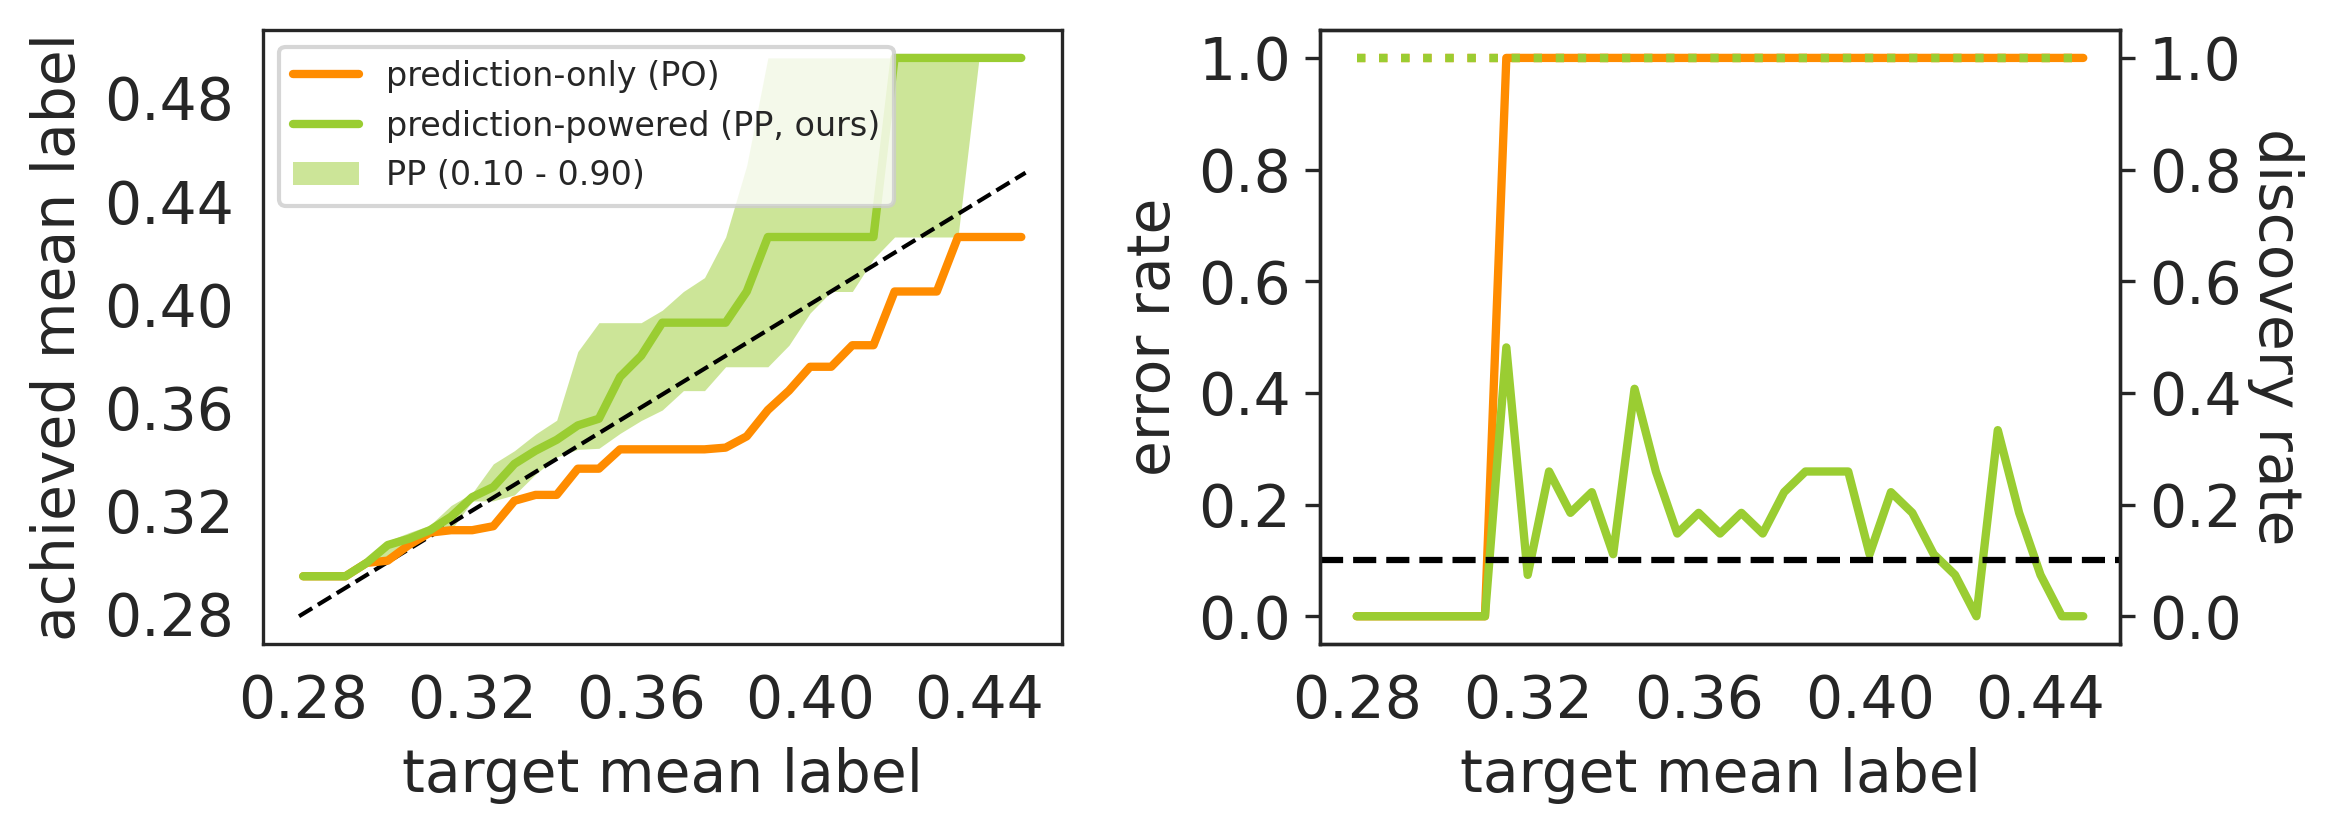

In [9]:
# plot results
plt.rcParams["font.size"] = 14
sns.set_style('white')
fig, axs = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

alpha = 0.1
imp_color = 'darkorange'
pp_color = 'yellowgreen'
q_low = 0.1
q_high = 0.9
# trial_idx = 0
offset = 0.001
example_targets = np.arange(np.min(target_values), np.max(target_values), 0.3)

axs[0].plot(
    [np.min(target_values) - offset, np.max(target_values) + offset],
    [np.min(target_values) - offset, np.max(target_values) + offset],
    '--k', linewidth=1
);
axs[0].plot(
    target_values, impworst_v, c=imp_color, label='prediction-only (PO)', linewidth=2,
)
axs[0].plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in ppworst_v],
    c=pp_color, label='prediction-powered (PP, ours)', linewidth=2,
)
axs[0].fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
    color=pp_color, alpha=0.5, label='PP ({:.2f} - {:.2f})'.format(q_low, q_high), linewidth=0
)
# max_achievable = np.max(list(temp2exceedance.values())) if run_exceedance else np.max(list(temp2mean.values()))
# axs[0].axvline(max_achievable, linestyle='--', color='k', alpha=0.2, label='max achievable')
axs[0].legend(fontsize=8)
axs[0].set_xlabel('target mean label');
axs[0].set_ylabel('achieved mean label');
axs[0].set_xticks(np.arange(np.min(target_values), np.max(target_values), 0.04))
axs[0].set_yticks(np.arange(np.min(target_values), 0.5, 0.04))
# axs[0].set_xlim([0.34, 0.45])
# axs[0].set_ylim([0.34, 0.50])

axs[1].set_ylabel('error rate');
axs[1].set_xlabel('target mean label');
axs[1].set_ylim([-0.05, 1.05])
axs[1].set_xticks(np.arange(np.min(target_values), np.max(target_values), 0.04))
axs[1].set_yticks(np.arange(0, 1.1, 0.2))

disc_ax = axs[1].twinx()
disc_ax.plot(target_values, imperr_v, c=imp_color, linewidth=2, label='PO error');
disc_ax.plot(target_values, impdisc_v, ':', c=imp_color, linewidth=2, label='PO discovery');
disc_ax.plot(target_values, pperr_v, c=pp_color, linewidth=2, label='PP error (ours)');
disc_ax.plot(target_values, ppdisc_v, ':', c=pp_color, linewidth=2, label='PP discovery (ours)');
disc_ax.axhline(alpha, linestyle='--', color='k', linewidth=1.5, label=r'$\alpha = {}$'.format(alpha));
# disc_ax.legend(fontsize=8)
disc_ax.set_ylabel('discovery rate', rotation=270, labelpad=15);
disc_ax.set_yticks(np.arange(0, 1.1, 0.2))

fig.tight_layout()

# plots of what causes false discoveries

In [ ]:
# plot which design names are causing PP false discoveries
width = 0.002
sns.set_style('whitegrid')
plt.figure(figsize=(12, 2))

cm = pylab.get_cmap('tab20c')
def name2color(name):
    if 'adalead' in name:
        if 'ridge' in name:
            return cm(0)
        if 'ff' in name:
            return cm(1)
        if 'cnn' in name:
            return cm(3)
    if 'biswas' in name:
        if 'ridge' in name:
            return cm(4)
        if 'ff' in name:
            return cm(5)
        if 'cnn' in name:
            return cm(7)
    if 'cbas' in name:
        if 'ridge' in name:
            return cm(8)
    if 'dbas' in name:
        if 'ridge' in name:
            return cm(12)
        if 'ff' in name:
            return cm(13)
        if 'cnn' in name:
            return cm(15)
    if 'pex' in name:
        if 'ridge' in name:
            return cm(16)
        if 'ff' in name:
            return cm(17)
        if 'cnn' in name:
            return cm(19)

valerrcount_n = []
for name in design_names:
    valerrcount = []
    
    for v, val in enumerate(target_values):
        val = round(val, 4)
        valerrcount.append(val2pperrnames[val][name])
        
    valerrcount_n.append(valerrcount)

bottom = np.zeros(target_values.size)
used_colors = []
for n, name in enumerate(design_names):
    valerrcount = valerrcount_n[n]
    color = name2color(name)
    plt.bar(target_values, valerrcount, width,
            label=name if color not in used_colors else None, bottom=bottom, color=color)
    bottom += valerrcount
    used_colors.append(color)
        
plt.legend(bbox_to_anchor=(1, -0.2), fontsize=8);
plt.xticks(target_values[::2], fontsize=10);
plt.xlabel('target value');
plt.ylabel(f'# false disc / {n_trial}');
plt.title('PP false discoveries');

In [ ]:
# ditto, for imputation
width = 0.002
sns.set_style('whitegrid')
plt.figure(figsize=(12, 2))

cm = pylab.get_cmap('tab20c')
valerrcount_n = []
for name in design_names:
    valerrcount = []
    
    for v, val in enumerate(target_values):
        val = round(val, 4)
        valerrcount.append(1 if name in val2imperrnames[val] else 0)
        
    valerrcount_n.append(valerrcount)

bottom = np.zeros(target_values.size)
for n, name in enumerate(design_names):
    valerrcount = valerrcount_n[n]
    plt.bar(target_values, valerrcount, width, label=name, bottom=bottom, color=name2color(name))
    bottom += valerrcount 
        
# plt.legend(bbox_to_anchor=(1, -0.2), fontsize=8);
plt.xticks(target_values[::2], fontsize=10);
plt.xlabel('target value');
plt.ylabel(f'# false discovery trials / {n_trial}');
plt.title('imputation false discoveries');